In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore')


Importando os pacotes necessários

In [2]:
from keras.datasets import mnist
objects = mnist
(X_train,Y_train), (X_test,Y_test) = objects.load_data()

In [3]:
print("Number of training examples :", X_train.shape[0], "and each image is of shape (%d, %d)"%(X_train.shape[1], X_train.shape[2]))
print("Number of test examples :", X_test.shape[0], "and each image is of shape (%d, %d)"%(X_test.shape[1], X_test.shape[2]))

Number of training examples : 60000 and each image is of shape (28, 28)
Number of test examples : 10000 and each image is of shape (28, 28)


Carregando database

60000


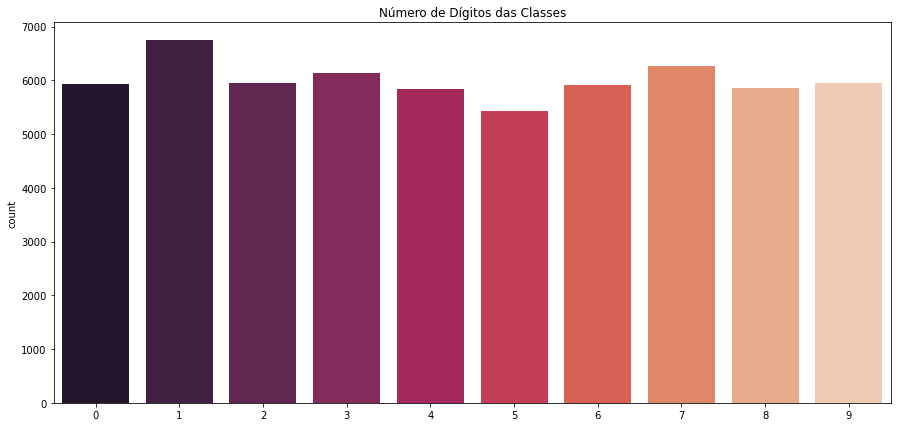

In [4]:
plt.figure(figsize=(15,7))
g = sns.countplot(Y_train, palette="rocket")
plt.title("Número de Dígitos das Classes")
print(Y_train.size)

Visualizando a database e sua distribuição de entradas

In [5]:
X_train = X_train / 255.0
X_test = X_test / 255.0
print("x_train shape: ",X_train.shape)
print("x_test shape: ",X_test.shape)

x_train shape:  (60000, 28, 28)
x_test shape:  (10000, 28, 28)


Normalizando a entrada. [0-1] ao invés de [0-255]

In [6]:
X_train = X_train.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)
print("x_train shape: ",X_train.shape)
print("x_test shape: ",X_test.shape)

x_train shape:  (60000, 28, 28, 1)
x_test shape:  (10000, 28, 28, 1)


As imagens estão em uma estrutura de dados como vetores 1D, por isso estamos transformando as imagens em 28x28x1 3D, como as imagens são em escala de cinza, nós usamos apenas um canal.

In [7]:
from keras.utils.np_utils import to_categorical
Y_train = to_categorical(Y_train, num_classes = 10)
Y_test = to_categorical(Y_test, num_classes = 10)

Categorização das labels para one-hot vectors, por exemplo,  3 -> [0,0,0,1,0,0,0,0,0,0]

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)
print("x_train shape",X_train.shape)
print("x_val shape",X_val.shape)
print("y_train shape",Y_train.shape)
print("y_val shape",Y_val.shape)

x_train shape (54000, 28, 28, 1)
x_val shape (6000, 28, 28, 1)
y_train shape (54000, 10)
y_val shape (6000, 10)


Nós dividimos os dados de treinamento em duas partes, 90% para de fato utilizar no treinamento e 10% para utilizar como dados de validação para evitar overfitting

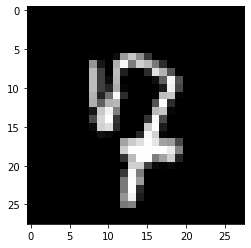

In [9]:
plt.imshow(X_train[2][:,:,0],cmap='gray')
plt.show()

Apenas um exemplo de uma imagem dos dados

In [10]:
import itertools
import tensorflow
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

model = Sequential()

#
model.add(Conv2D(filters = 8, kernel_size = (4,4),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 16, kernel_size = (4,4),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.1))
#
model.add(Conv2D(filters = 16, kernel_size = (4,4),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (4,4),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.1))
# fully connected
model.add(Flatten())
model.add(Dense(1024, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(10, activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 8)         136       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        2064      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 16)        4112      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0

In [11]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

In [12]:
# Compile the model
metrics = ["accuracy", tensorflow.metrics.Recall(), tensorflow.metrics.Precision()]
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=metrics)

In [13]:
epochs = 10  # for better result increase the epochs
batch_size = 250

In [14]:
# data augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [15]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val), steps_per_epoch=X_train.shape[0] // batch_size)

Epoch 1/10
216/216 [==============================] - 56s 252ms/step - loss: 0.4152 - accuracy: 0.8664 - recall: 0.8197 - precision: 0.9296 - val_loss: 0.0711 - val_accuracy: 0.9790 - val_recall: 0.9770 - val_precision: 0.9814
Epoch 2/10
216/216 [==============================] - 55s 254ms/step - loss: 0.1068 - accuracy: 0.9667 - recall: 0.9621 - precision: 0.9721 - val_loss: 0.0482 - val_accuracy: 0.9852 - val_recall: 0.9840 - val_precision: 0.9871
Epoch 3/10
216/216 [==============================] - 53s 247ms/step - loss: 0.0805 - accuracy: 0.9747 - recall: 0.9717 - precision: 0.9786 - val_loss: 0.0422 - val_accuracy: 0.9865 - val_recall: 0.9855 - val_precision: 0.9878
Epoch 4/10
216/216 [==============================] - 50s 230ms/step - loss: 0.0608 - accuracy: 0.9817 - recall: 0.9794 - precision: 0.9845 - val_loss: 0.0370 - val_accuracy: 0.9882 - val_recall: 0.9872 - val_precision: 0.9893
Epoch 5/10
216/216 [==============================] - 53s 247ms/step - loss: 0.0518 - accura

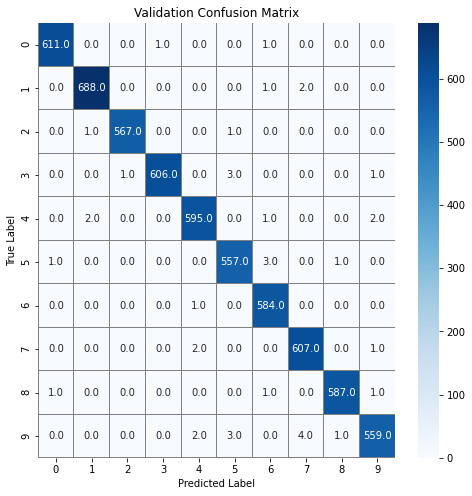

In [16]:
# confusion matrix
import seaborn as sns
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
dale = model.predict_classes(X_val)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Validation Confusion Matrix")
plt.show()

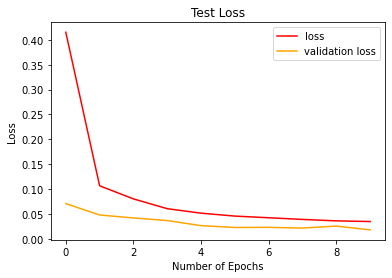

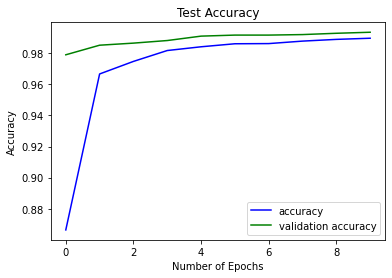

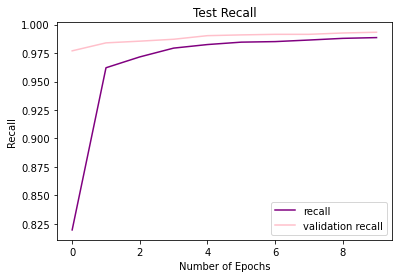

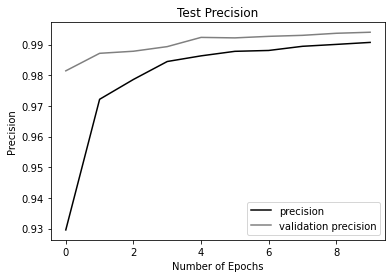

In [17]:
# Plotando gráfico de Loss
plt.plot(history.history['loss'], color='r', label="loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.plot(history.history['val_loss'], color="orange", label="validation loss")
plt.legend()
plt.show()

# Plotando gráfico de Accuracy
plt.plot(history.history['accuracy'], color='b', label="accuracy")
plt.title("Test Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.plot(history.history['val_accuracy'], color='g', label="validation accuracy")
plt.legend()
plt.show()

# Plotando gráfico de Recall
plt.plot(history.history['recall'], color="purple", label="recall")
plt.title("Test Recall")
plt.xlabel("Number of Epochs")
plt.ylabel("Recall")
plt.plot(history.history['val_recall'], color="pink", label="validation recall")
plt.legend()
plt.show()


# Plotando gráfico de Precision
plt.plot(history.history['precision'], color="black", label="precision")
plt.title("Test Precision")
plt.xlabel("Number of Epochs")
plt.ylabel("Precision")
plt.plot(history.history['val_precision'], color="gray", label="validation precision")
plt.legend()
plt.show()

In [18]:
print(classification_report(Y_true, dale))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       613
           1       1.00      1.00      1.00       691
           2       1.00      1.00      1.00       569
           3       1.00      0.99      1.00       611
           4       0.99      0.99      0.99       600
           5       0.99      0.99      0.99       562
           6       0.99      1.00      0.99       585
           7       0.99      1.00      0.99       610
           8       1.00      0.99      1.00       590
           9       0.99      0.98      0.99       569

    accuracy                           0.99      6000
   macro avg       0.99      0.99      0.99      6000
weighted avg       0.99      0.99      0.99      6000



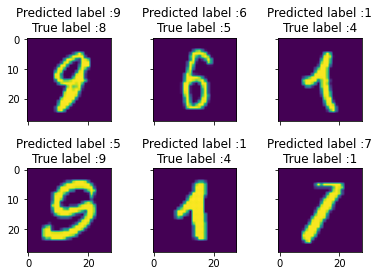

In [19]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,gridspec_kw= {'wspace':0.5, 'hspace':0.5},sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

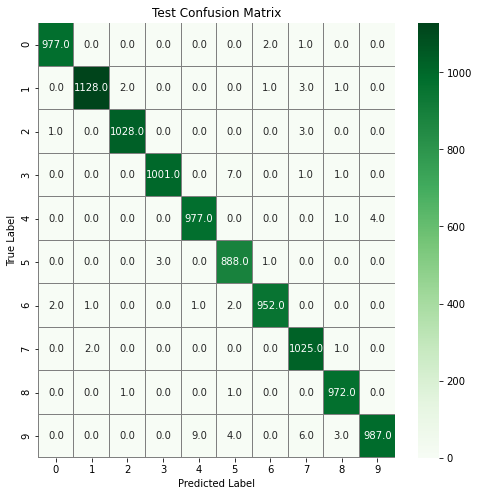

In [20]:
# Predict the values from the test dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_test,axis = 1)
cr = model.predict_classes(X_test)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Test Confusion Matrix")
plt.show()

In [21]:
score = model.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])
print(classification_report(Y_true, cr))

Test score: 0.017339179292321205
Test accuracy: 0.9934999942779541
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      0.99      1.00      1135
           2       1.00      1.00      1.00      1032
           3       1.00      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.98      1.00      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      1.00      0.99      1028
           8       0.99      1.00      1.00       974
           9       1.00      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



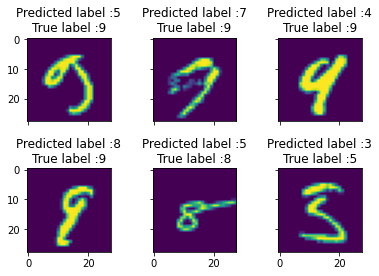

In [22]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_test_errors = X_test[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,gridspec_kw= {'wspace':0.5, 'hspace':0.5},sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_test_errors, Y_pred_classes_errors, Y_true_errors)